# Double Jet

With various grid sizes

In [1]:
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.DoubleJetPlot import *

Get initial arguments from class

In [4]:
from gpuocean.utils import DoubleJetCase

In [5]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [6]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-09-15T15_08_08"

true_state = np.load(os.path.join(truth_path, "truth_864000.npy"))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

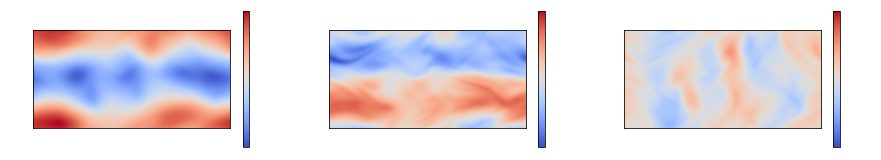

In [7]:
imshow3(true_state, eta_vlim=4)

## Ensembles

In [8]:
from utils.DoubleJetSL import *

In [9]:
def plot_SLstates(sl_state):
    from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
    from mpl_toolkits.axes_grid1.colorbar import colorbar

    fig, axs = plt.subplots(3,3, figsize=(20,15))

    def _add_cb(ax, im, label=None):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(label)


    SL_mean = np.mean(sl_state, axis=-1)
    vlims = [4, 750, 750]
    for i in range(3):
        im = axs[0,i].imshow(SL_mean[i], cmap=plt.cm.coolwarm, vmin=-vlims[i], vmax=vlims[i])
        _add_cb(axs[0,i], im)

    SL_std = np.std(sl_state, axis=-1, ddof=1)
    vlims = [0.5, 100, 100]
    for i in range(3):
        im = axs[1,i].imshow(SL_std[i], cmap=plt.cm.Oranges, vmin=0, vmax=vlims[i])
        _add_cb(axs[1,i], im)

    rescale = true_state.shape[1]//sl_state.shape[1]
    SL_err = np.abs(np.mean(sl_state, axis=-1).repeat(rescale,1).repeat(rescale,2) - true_state) 
    vlims = [0.5, 100, 100]
    for i in range(3):
        im = axs[2,i].imshow(SL_err[i], cmap=plt.cm.Reds, vmin=0, vmax=vlims[i])
        _add_cb(axs[2,i], im)

In [10]:
slda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/SLDA/2023-09-20T09_04_01L8"

sl_state = np.load(os.path.join(slda_path, "SLstates/SLensemble_864000.npy"))

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  This is separate from the ipykernel package so we can avoid doing imports until


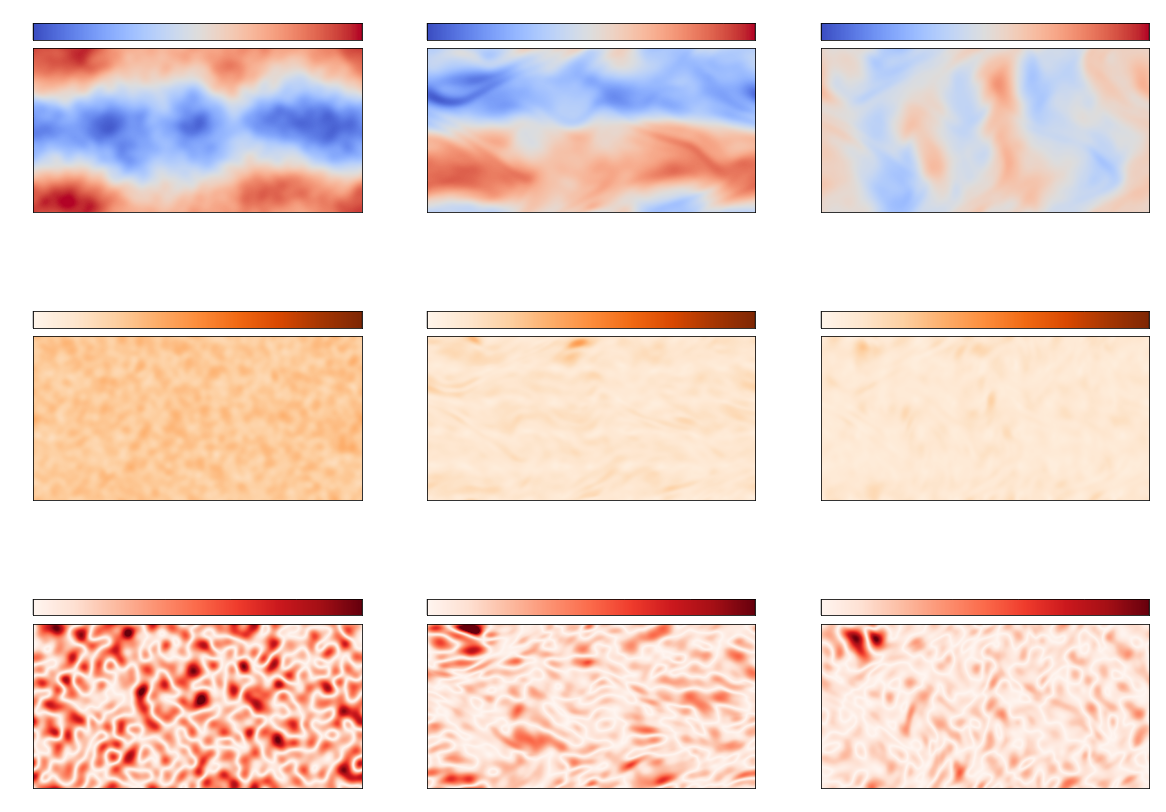

In [11]:
plot_SLstates(sl_state)

In [12]:
slda2_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/SLDA/2023-09-20T10_27_40L7"

sl2_state = np.load(os.path.join(slda2_path, "SLstates/SLensemble_864000.npy"))

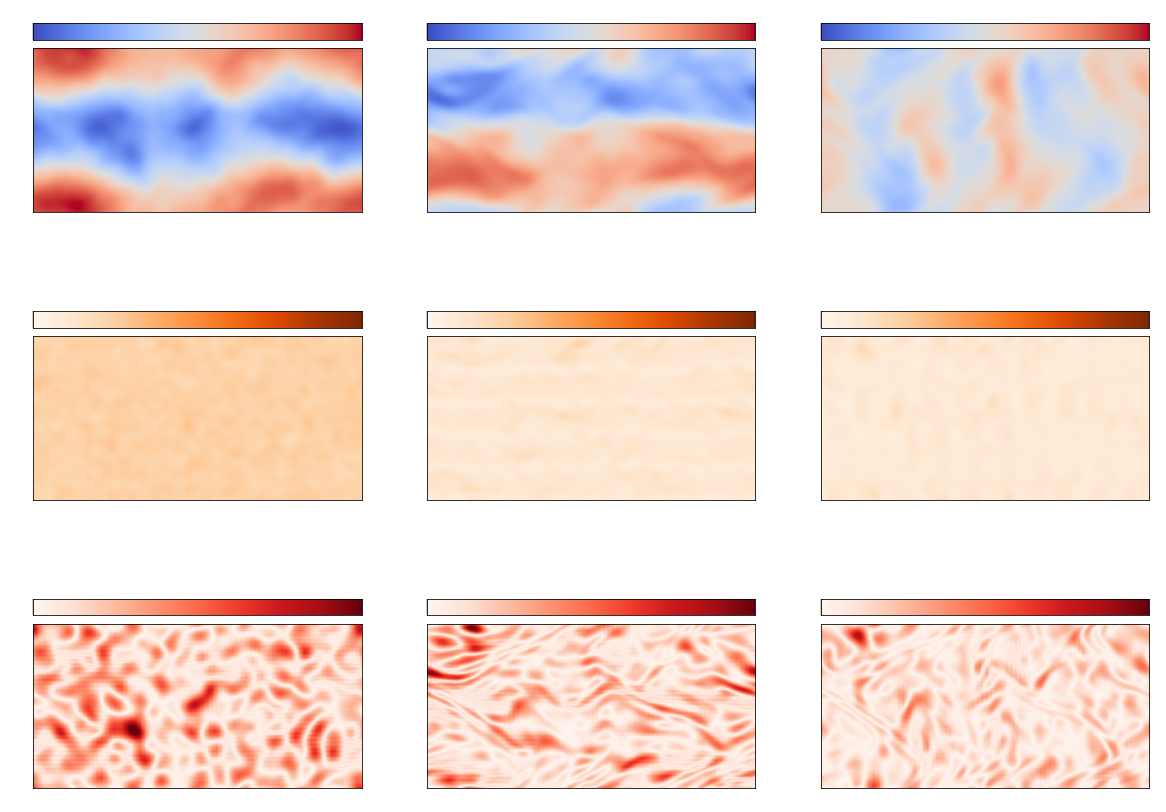

In [13]:
plot_SLstates(sl2_state)

In [14]:
slda3_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/SLDA/2023-09-20T11_23_28L6"

sl3_state = np.load(os.path.join(slda3_path, "SLstates/SLensemble_864000.npy"))

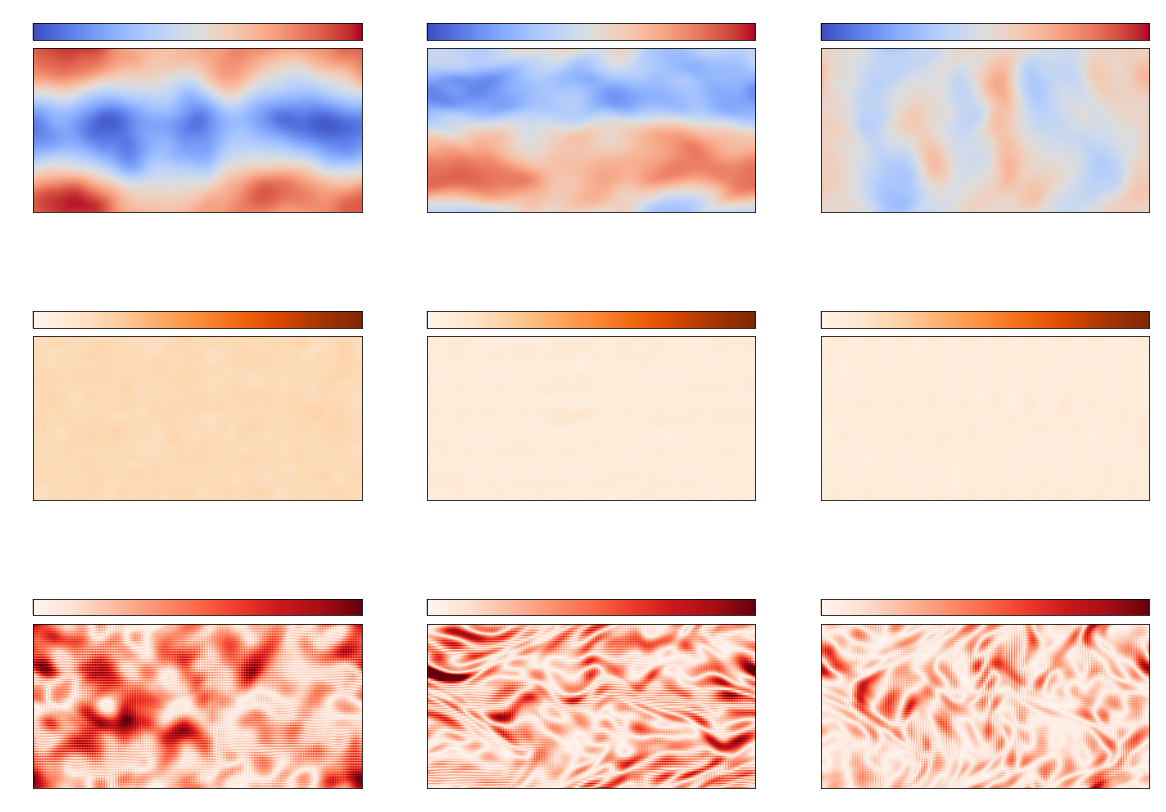

In [15]:
plot_SLstates(sl3_state)

In [16]:
def MLestimator(ML_state, func, **kwargs):
    numLevels = len(ML_state)
    MLest = np.zeros(ML_state[-1][0].shape[:-1])
    MLest += func(ML_state[0], axis=-1, **kwargs).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2)
    for l_idx in range(1, numLevels):
        MLest += (func(ML_state[l_idx][0], axis=-1, **kwargs) - func(ML_state[l_idx][1], axis=-1, **kwargs).repeat(2,1).repeat(2,2)).repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2)
    return MLest

In [17]:
def plot_MLstates(ml_state):
    from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
    from mpl_toolkits.axes_grid1.colorbar import colorbar

    from gpuocean.ensembles import MultiLevelOceanEnsemble
    fig, axs = plt.subplots(3,3, figsize=(20,15))

    def _add_cb(ax, im, label=None):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(label)


    ML_mean = MLestimator(ml_state, np.mean)
    vlims = [4, 750, 750]
    for i in range(3):
        im = axs[0,i].imshow(ML_mean[i], cmap=plt.cm.coolwarm, vmin=-vlims[i], vmax=vlims[i])
        _add_cb(axs[0,i], im)

    ML_std = MLestimator(ml_state, np.std, ddof=1)
    vlims = [0.5, 100, 100]
    for i in range(3):
        im = axs[1,i].imshow(ML_std[i], cmap=plt.cm.Oranges, vmin=0, vmax=vlims[i])
        _add_cb(axs[1,i], im)

    ML_err = np.abs(ML_mean - true_state) 
    vlims = [0.5, 100, 100]
    for i in range(3):
        im = axs[2,i].imshow(ML_err[i], cmap=plt.cm.Reds, vmin=0, vmax=vlims[i])
        _add_cb(axs[2,i], im)

In [18]:
mlda2_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/MLDA/2023-09-19T14_10_37ls87"

ML2_state = []

ML2_state.append(np.load(mlda2_path+"/MLstates/MLensemble_0.npy"))

numLevels = len(set([f.split("_")[1][0] for f in os.listdir(mlda2_path+"/MLstates")]))
for l_idx in range(1, numLevels):
    ML2_state.append( [np.load(mlda2_path+"/MLstates/MLensemble_"+str(l_idx)+"_0.npy"), np.load(mlda2_path+"/MLstates/MLensemble_"+str(l_idx)+"_1.npy")] )


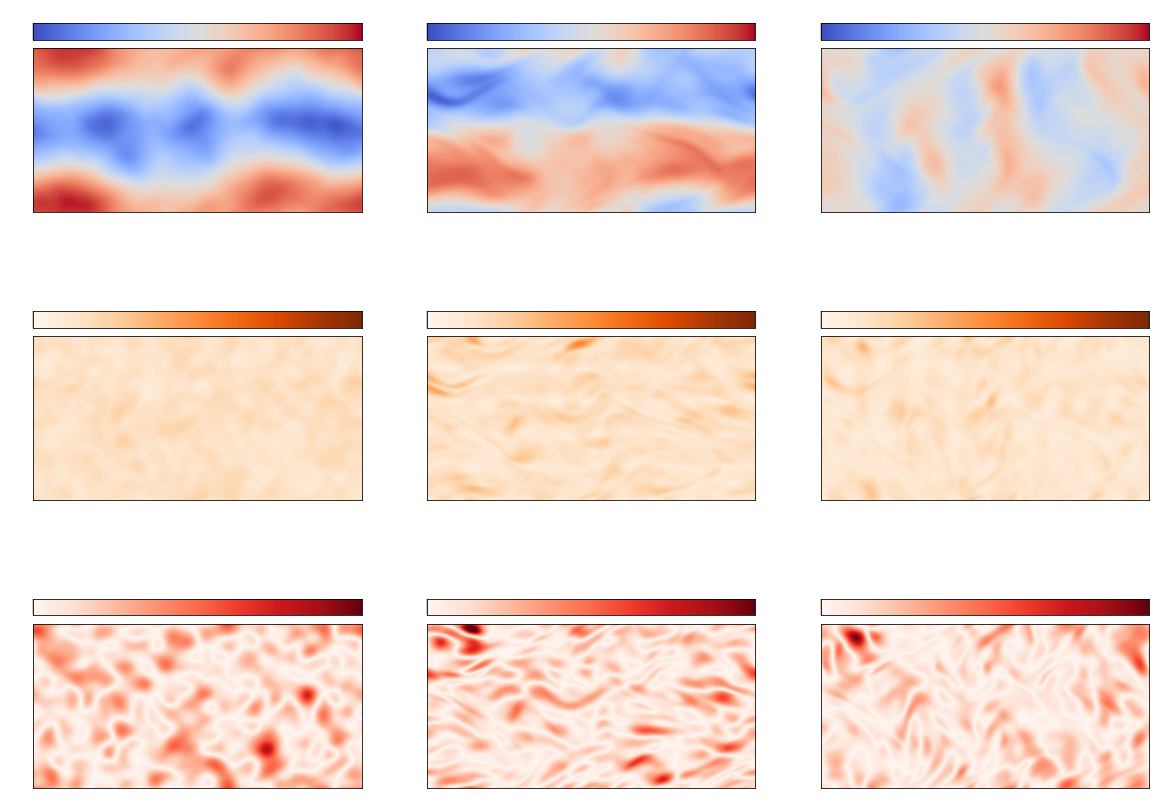

In [19]:
plot_MLstates(ML2_state)

In [22]:
mlda3_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/MLDA/2023-09-20T16_53_50ls876"

ML3_state = []

ML3_state.append(np.load(mlda3_path+"/MLstates/MLensemble_0.npy"))

numLevels = len(set([f.split("_")[1][0] for f in os.listdir(mlda3_path+"/MLstates")]))
for l_idx in range(1, numLevels):
    ML3_state.append( [np.load(mlda3_path+"/MLstates/MLensemble_"+str(l_idx)+"_0.npy"), np.load(mlda3_path+"/MLstates/MLensemble_"+str(l_idx)+"_1.npy")] )

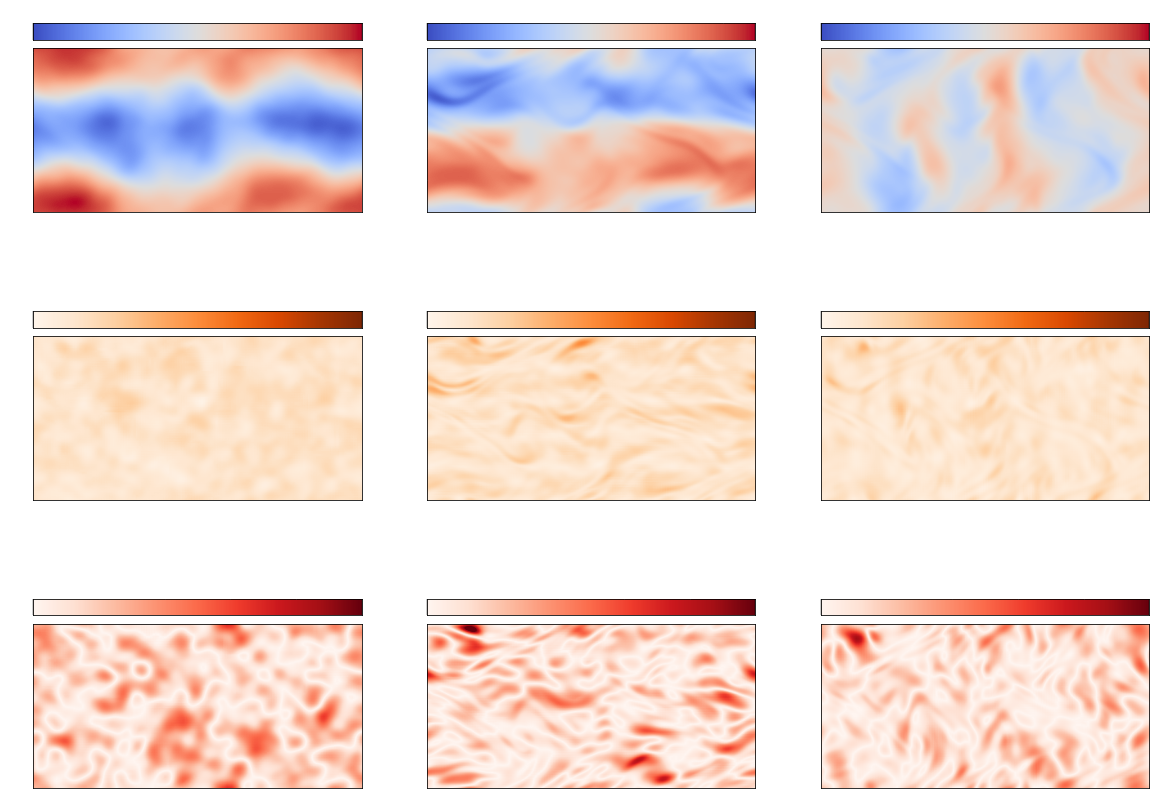

In [23]:
plot_MLstates(ML3_state)

In [20]:
def MLMSE(ML_state, true_state):
    numLevels = len(ML_state)
    MLest = np.zeros(ML_state[-1][0].shape[:-1])
    MLest += np.mean((ML_state[0].repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2) - true_state[:,:,:,np.newaxis])**2, axis=-1) 
    for l_idx in range(1, numLevels):
        MLest += np.mean((ML_state[l_idx][0].repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2) - true_state[:,:,:,np.newaxis])**2
                          - (ML_state[l_idx][1].repeat(2**(numLevels-l_idx),1).repeat(2**(numLevels-l_idx),2) - true_state[:,:,:,np.newaxis])**2,
                          axis=-1)
    return np.sqrt(np.maximum(0,MLest))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

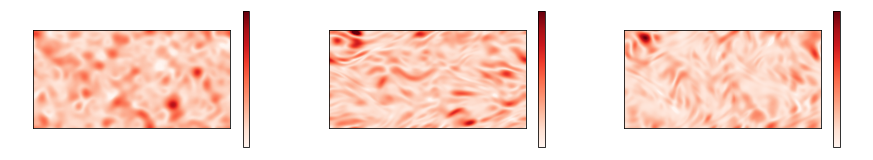

In [21]:
imshow3var(MLMSE(ML2_state, true_state), eta_vlim=0.5, huv_vlim=100)

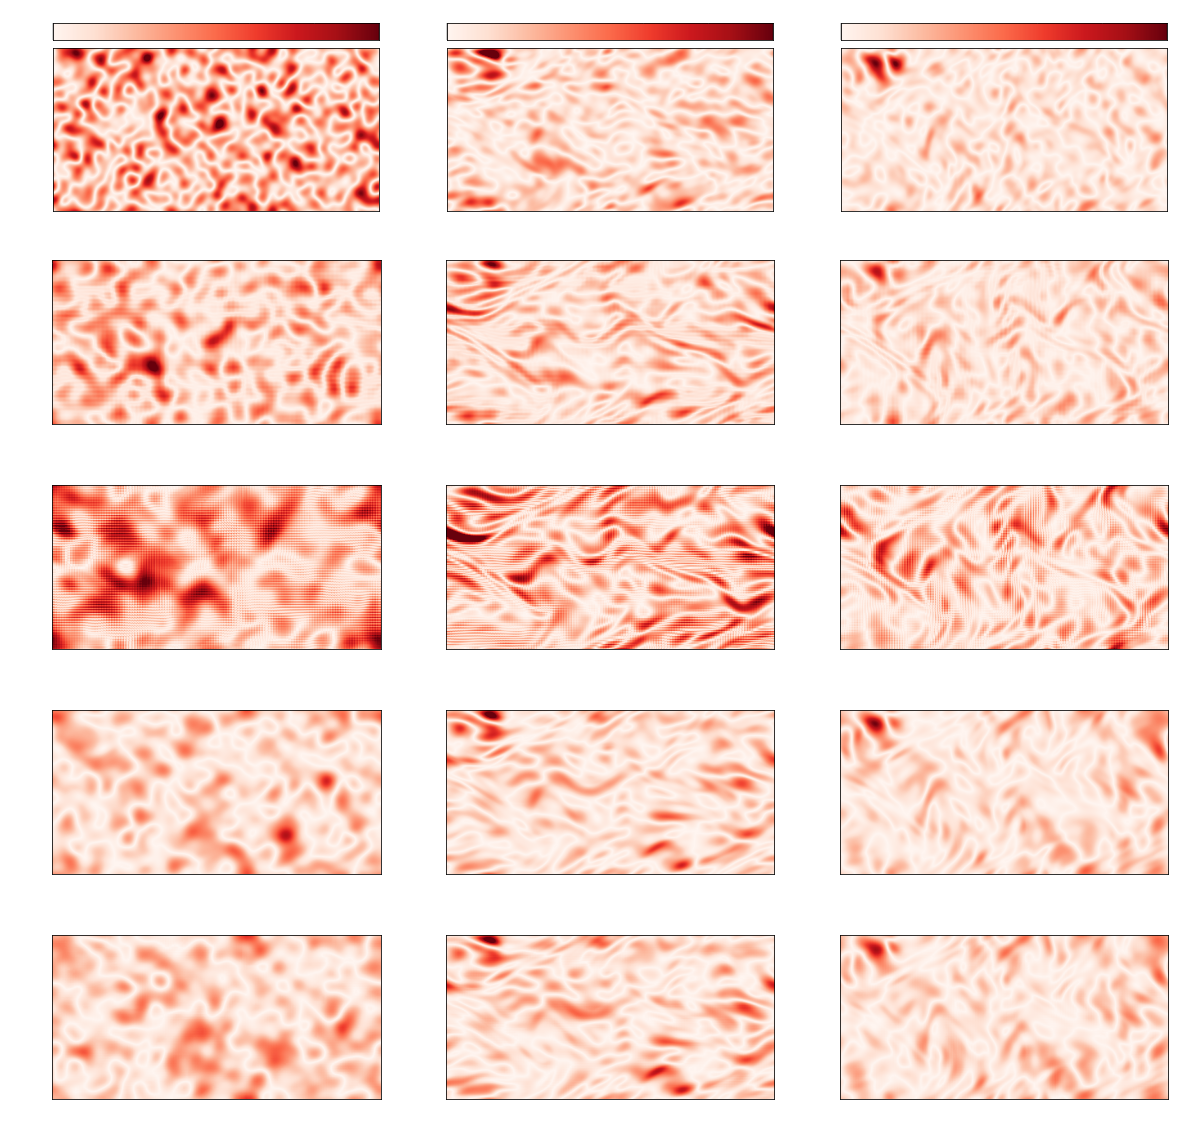

In [59]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

fig, axs = plt.subplots(5,3, figsize=(20,20))

def _add_cb(ax, im, label=None):
    ax_divider = make_axes_locatable(ax)
    ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
    cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
    ax_cb.xaxis.set_ticks_position("top")
    ax_cb.set_title(label)

vlims=[0.5, 100, 100]
def _plot3(axs, state, cbar=False):
    for i in range(3):
        im = axs[i].imshow(state[i], cmap=plt.cm.Reds, vmin=0, vmax=vlims[i])
        if cbar:
            _add_cb(axs[i], im)
    axs[2].yaxis.set_label_position("right")
    axs[2].set_ylabel(",     ".join(["{:.1f}".format(v) for v in np.linalg.norm(state, axis=(1,2))]), fontsize=14)


axs[0,0].set_ylabel("SL", fontsize=16)
SL_err = np.abs(np.mean(sl_state, axis=-1).repeat(1,1).repeat(1,2) - true_state)
_plot3(axs[0], SL_err, cbar=True) 

axs[1,0].set_ylabel("SL (1 level coarser)", fontsize=16)
SL2_err = np.abs(np.mean(sl2_state, axis=-1).repeat(2,1).repeat(2,2) - true_state)
_plot3(axs[1], SL2_err) 

axs[2,0].set_ylabel("SL (2 level coarser)", fontsize=16)
SL3_err = np.abs(np.mean(sl3_state, axis=-1).repeat(4,1).repeat(4,2) - true_state)
_plot3(axs[2], SL3_err) 

axs[3,0].set_ylabel("ML (2 levels)", fontsize=16)
ML2_err = np.abs(MLestimator(ML2_state, np.mean) - true_state)
_plot3(axs[3], ML2_err) 

axs[4,0].set_ylabel("ML (3 levels)", fontsize=16)
ML3_err = np.abs(MLestimator(ML3_state, np.mean) - true_state)
_plot3(axs[4], ML3_err) 
